In [1]:
# !pip install gcsfs

from glob import glob
import math, os, time, re, json, shutil, pprint, random, gc
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets

print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, MaxPooling2D, Activation, GlobalMaxPooling2D, concatenate
from tensorflow.keras.layers import Conv2D, Dropout, BatchNormalization, Input, SeparableConv2D, Flatten
from tensorflow.keras.layers import add as add_concat
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from IPython.display import clear_output
import IPython.display as display

import warnings
warnings.filterwarnings("ignore")
np.random.seed(0)

Tensorflow version 2.1.0


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [3]:
# TEST_DS_PATH = KaggleDatasets().get_gcs_path('testtfrecords')
# GCS_DS_PATH = KaggleDatasets().get_gcs_path('tfrecords-bengali-grapheme')
# !gsutil ls $GCS_DS_PATH

TEST_DS_PATH = '/kaggle/input/testtfrecords'
GCS_DS_PATH = '/kaggle/input/tfrecords-bengali-grapheme'

In [4]:
if strategy.num_replicas_in_sync == 1: # single GPU or CPU
    BATCH_SIZE = 64
    VALIDATION_BATCH_SIZE = 64
else: # TPU pod
    BATCH_SIZE = 8 * strategy.num_replicas_in_sync
    VALIDATION_BATCH_SIZE = 8 * strategy.num_replicas_in_sync
    
FILENAMES = tf.io.gfile.glob(GCS_DS_PATH+'/*.tfrec')
TEST_FILENAMES  = tf.io.gfile.glob(TEST_DS_PATH+'/*.tfrec')

IMAGE_SIZE = [64, 64]
IMAGE_TARGET = [64, 64]
if K.image_data_format() == 'channels_first':
    SHAPE = (3,*IMAGE_SIZE)
    INPUT_SHAPE = (3, *IMAGE_TARGET)
else:
    SHAPE = (*IMAGE_SIZE, 3)
    INPUT_SHAPE = (*IMAGE_TARGET, 3)
SIZE_TFRECORD = 128
split = int(len(FILENAMES)*0.81)
TRAINING_FILENAMES = FILENAMES[:split]
VALIDATION_FILENAMES = FILENAMES[split:]
STEP_PER_EPOCH = ((len(TRAINING_FILENAMES)*SIZE_TFRECORD)//BATCH_SIZE)*2
VALIDATION_STEP_PER_EPOCH = (len(VALIDATION_FILENAMES)*SIZE_TFRECORD)//VALIDATION_BATCH_SIZE
print(len(TRAINING_FILENAMES))
print(len(VALIDATION_FILENAMES))

1271
299


In [5]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))


def transform(image,label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 0.8 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 0.8 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]),label

In [6]:
def read_tfrecord(example):
    features = {
      "image": tf.io.FixedLenFeature([], tf.string), 
      "grapheme_root": tf.io.FixedLenFeature([], tf.int64),       
      "vowel_diacritic": tf.io.FixedLenFeature([], tf.int64),       
      "consonant_diacritic": tf.io.FixedLenFeature([], tf.int64),  

      "label":         tf.io.FixedLenFeature([], tf.string),         
      "size":          tf.io.FixedLenFeature([2], tf.int64),     
      "head_root_hot": tf.io.VarLenFeature(tf.float32),
      "head_vowel_hot": tf.io.VarLenFeature(tf.float32),
      "head_consonant_hot": tf.io.VarLenFeature(tf.float32),
    }

    example = tf.io.parse_single_example(example, features)

    image = tf.image.decode_image(example['image'], channels=3)

     
    head_root_hot = tf.sparse.to_dense(example['head_root_hot'])
    head_vowel_hot = tf.sparse.to_dense(example['head_vowel_hot'])
    head_consonant_hot = tf.sparse.to_dense(example['head_consonant_hot'])
    
    head_root_hot = tf.reshape(head_root_hot, [168])
    head_vowel_hot = tf.reshape(head_vowel_hot, [11])
    head_consonant_hot = tf.reshape(head_consonant_hot, [7])

    return image,  {"head_root": head_root_hot, "head_vowel": head_vowel_hot, "head_consonant": head_consonant_hot}
option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False

def resize_and_crop_image(image, label):
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = IMAGE_TARGET[1]
    th = IMAGE_TARGET[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                   )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def normalize(image, label):
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    image = tf.cast(image, tf.float32)/255.0 
    # image = tf.image.per_image_standardization(image)
    return image, label


def augmentation(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, k=random.randrange(4))
    image = tf.image.random_saturation(image, 0, 2)
    image = tf.image.random_hue(image, 0.08)
    image = tf.image.random_contrast(image, 0.7, 1.3)
    image = tf.image.random_brightness(image, 0.15)
    return image, label


def force_image_sizes(dataset):
    reshape_images = lambda image, label: (tf.reshape(image, SHAPE), label)   
    dataset = dataset.map(reshape_images, num_parallel_calls=AUTO)
    return dataset

def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) 
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
#     dataset = dataset.map(resize_and_crop_image, num_parallel_calls=AUTO)
    return dataset


def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES)
    dataset = dataset.map(transform, num_parallel_calls=AUTO)
    dataset = dataset.map(normalize, num_parallel_calls=AUTO)
    dataset = force_image_sizes(dataset)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2000)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_validation_dataset():
    dataset = load_dataset(VALIDATION_FILENAMES)
    dataset = dataset.map(normalize, num_parallel_calls=AUTO)
    dataset = force_image_sizes(dataset)
    dataset = dataset.batch(VALIDATION_BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) 
    return dataset

In [7]:
# Matplotlib config
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0', figsize=(16,9))
# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

def plot_learning_rate(lr_func, epochs):
    xx = np.arange(epochs+1, dtype=np.float)
    y = [lr_decay(x) for x in xx]
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.set_xlabel('epochs')
    ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
    ax.minorticks_on()
    ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    ax.step(xx,y, linewidth=3, where='post')
    display.display(fig)
   
        
class PlotTraining(tf.keras.callbacks.Callback):
    def __init__(self, sample_rate=1, zoom=1):
        self.sample_rate = sample_rate
        self.step = 0
        self.zoom = zoom
        self.steps_per_epoch = STEP_PER_EPOCH

    def on_train_begin(self, logs={}):
        self.batch_history = {}
        self.batch_step = []
        self.epoch_history = {}
        self.epoch_step = []
        self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
        self.fig.subplots_adjust(wspace=0.3, hspace=0.25)
        plt.ioff()

    def on_batch_end(self, batch, logs={}):
        if (batch % self.sample_rate) == 0:
            self.batch_step.append(self.step)
            for k,v in logs.items():
              # do not log "batch" and "size" metrics that do not change
              # do not log training accuracy "acc"
                if k=='batch' or k=='size' or k == 'loss':# or k=='acc':
                    continue
                self.batch_history.setdefault(k, []).append(v)
        self.step += 1

    def on_epoch_end(self, epoch, logs={}):
        plt.close(self.fig)
        self.axes[0].cla()
        self.axes[1].cla()
      
        self.axes[0].set_ylim(0, 1.2/self.zoom)
        self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
        self.epoch_step.append(self.step)
        for k,v in logs.items():
          # only log validation metrics
            if not k.startswith('val_') or k == 'val_loss':
                continue
            self.epoch_history.setdefault(k, []).append(v)

        display.clear_output(wait=True)
    
        for k,v in self.batch_history.items():
            if isinstance(v, list) and len(v) > 0:
                label='{}: {:.3f}'.format(k, v[len(v)-1])
                self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=label)
            else:
                continue
        for k,v in self.epoch_history.items():
            if isinstance(v, list) and len(v) > 0:
                label='{}: {:.3f}'.format(k, v[len(v)-1])
                self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=label, linewidth=3)
            else:
                continue
        self.axes[0].legend()
        self.axes[1].legend()
        self.axes[0].set_xlabel('epochs')
        self.axes[1].set_xlabel('epochs')
        self.axes[0].minorticks_on()
        self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
        self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
        self.axes[1].minorticks_on()
        self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
        self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
        display.display(self.fig)


In [8]:
with strategy.scope():
    bnmomemtum=0.8
    def fire(x, squeeze, expand):
        y  = Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
        y  = BatchNormalization(momentum=bnmomemtum)(y)
        y1 = Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
        y1 = BatchNormalization(momentum=bnmomemtum)(y1)
        y3 = Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
        y3 = BatchNormalization(momentum=bnmomemtum)(y3)
        return concatenate([y1, y3])

    def fire_module(squeeze, expand):
        return lambda x: fire(x, squeeze, expand)

    img_input = Input(shape=INPUT_SHAPE) 

    y = Conv2D(kernel_size=3, filters=64, padding='same', use_bias=True, activation='relu')(img_input)
    y = BatchNormalization(momentum=bnmomemtum)(y)
    y = fire_module(48, 96)(y)
    y = MaxPooling2D(pool_size=2)(y)
    y = fire_module(96, 192)(y)
    y = MaxPooling2D(pool_size=2)(y)
    y = fire_module(192, 384)(y)
    y = MaxPooling2D(pool_size=2)(y)
    y = fire_module(384, 768)(y)

    y = GlobalAveragePooling2D()(y)
    
    y = Dense(1536)(y)
    y = Activation('relu')(y)
    y = Dropout(0.33)(y)

    head_root = Dense(168, activation='softmax', name='head_root')(y)
    head_vowel = Dense(11, activation='softmax', name='head_vowel')(y)
    head_consonant = Dense(7, activation='softmax', name='head_consonant')(y)

    model = Model(inputs=img_input, outputs=[head_root, head_vowel, head_consonant]) 
    
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 48)   3120        batch_normalization[0][0]        
______________________________________________________________________________________________

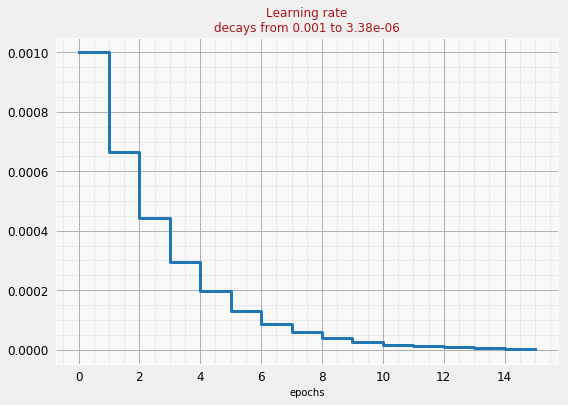

In [9]:
EPOCHS = 15
def lr_decay(epoch):
    return 0.001 * math.pow(0.666, epoch)

lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

plot_learning_rate(lr_decay, EPOCHS)

In [10]:
weight_path="{}_weights.squeeze.hdf5".format('model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_head_root_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True) 

plot_training = PlotTraining(sample_rate=10, zoom=1)
callbacks_list = [checkpoint, plot_training] #, lr_decay_callback

In [11]:
training_dataset = get_training_dataset()
validation_dataset = get_validation_dataset()

In [12]:
history = model.fit_generator(
    training_dataset, 
    steps_per_epoch=STEP_PER_EPOCH, 
    epochs=EPOCHS,
    validation_data=validation_dataset,
    validation_steps=VALIDATION_STEP_PER_EPOCH,
    callbacks=callbacks_list)

Train for 5084 steps, validate for 598 steps
Epoch 1/15
3896/5084 [=====================>........] - ETA: 1:27 - loss: 3.3701 - head_root_loss: 2.1091 - head_vowel_loss: 0.7288 - head_consonant_loss: 0.5323 - head_root_accuracy: 0.4822 - head_vowel_accuracy: 0.7449 - head_consonant_accuracy: 0.8216

In [13]:
model.load_weights(weight_path)
model.save('model_tpu_Squeeze.h5')

In [14]:
def read_test_tfrecord(example):
    TEST_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "label": tf.io.FixedLenFeature([], tf.string),  
    }
    example = tf.io.parse_single_example(example, TEST_TFREC_FORMAT)
    image = tf.image.decode_image(example['image'], channels=3)
    image_model = tf.cast(image, tf.float32)/255.0 
    image_model = tf.reshape(image_model, SHAPE)
    head_root_hot_classes =  [x for x in range(168)]
    head_vowel_hot_classes =  [x  for x in range(11)]
    head_consonant_hot_classes = [x  for x in range(7)]
    label = example['label']
    return image_model, label


def load_test_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order) 
    dataset = dataset.map(read_test_tfrecord, num_parallel_calls=AUTO)
    return dataset
def get_test_dataset(filenames):
    dataset = load_test_dataset(filenames)
    return dataset


In [15]:
test = get_test_dataset(TEST_FILENAMES)
test = test.batch(1)

In [16]:
predicts = []
for i , (image, label) in enumerate(test):
    predict =  model.predict(image)
    preds = []
    for pred in predict:
        preds += [np.argmax(pred, axis=1).tolist()[0]]
    predicts += [[preds, label[0].numpy().decode("utf-8")]]
predicts

[[[3, 1, 0], 'Test_0.png'],
 [[154, 1, 4], 'Test_10.png'],
 [[93, 2, 0], 'Test_1.png'],
 [[21, 2, 0], 'Test_11.png'],
 [[19, 0, 0], 'Test_2.png'],
 [[119, 9, 0], 'Test_8.png'],
 [[115, 0, 0], 'Test_3.png'],
 [[137, 7, 0], 'Test_7.png'],
 [[55, 4, 0], 'Test_4.png'],
 [[133, 10, 0], 'Test_9.png'],
 [[115, 2, 0], 'Test_5.png'],
 [[23, 9, 5], 'Test_6.png']]

In [17]:
import pandas as pd
row_ids = []
target = []
for pred in predicts:
    row_id = pred[1].split('.')[0]
    consonant = row_id+'_consonant_diacritic'
    root = row_id+'_grapheme_root'
    vowel = row_id+'_vowel_diacritic'
    row_ids.append(consonant)
    target.append(pred[0][2])
    row_ids.append(root)
    target.append(pred[0][0])
    row_ids.append(vowel)
    target.append(pred[0][1])        

df_sample = pd.DataFrame({
    'row_id': row_ids,
    'target':target
},columns=['row_id','target'])

df_sample.to_csv('submission.csv',index=False)
df_sample

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,3
2,Test_0_vowel_diacritic,1
3,Test_10_consonant_diacritic,4
4,Test_10_grapheme_root,154
5,Test_10_vowel_diacritic,1
6,Test_1_consonant_diacritic,0
7,Test_1_grapheme_root,93
8,Test_1_vowel_diacritic,2
9,Test_11_consonant_diacritic,0
